In [1]:
pip install requests pandas beautifulsoup4 tqdm unicode rapidfuzz yellowbrick  adjustText

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.9 MB/s eta 0:00:00


In [2]:
import re
import requests
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import pandas as pd
from collections import defaultdict
from collections import Counter
import unicodedata
from rapidfuzz import process, fuzz

In [3]:
# Sessão persistente para performance
session = requests.Session()

# Armazena as lutas por slug de lutador
lutas_por_lutador = defaultdict(list)

def slugify_name(full_name: str) -> str:
    """
    Converte um nome completo em slug:
    """
    clean = re.sub(r"[^\w\s-]", "", full_name, flags=re.UNICODE)
    parts = re.split(r"[\s]+", clean.strip())
    return "-".join(parts).lower()

def get_fighters():
    """
    Coleta da página A–Z os hrefs originais (?p=####) de cada lutador,
    garantindo que a URL exista e evitando 404 por slug incorreto.
    """
    url = "https://www.bjjheroes.com/a-z-bjj-fighters-list"
    resp = session.get(url, timeout=10)
    if resp.status_code != 200:
        print("Erro ao acessar a lista de lutadores.")
        return []
    soup = BeautifulSoup(resp.content, 'html.parser')
    fighter_ids = []
    for a in soup.select("td.column-1 a"):
        href = a.get("href")
        if href:
            fighter_ids.append(href)  # ex: "?p=8141"
    return fighter_ids

def scrape_fighter(fighter_id):
    """
    Usa o ID  para acessar o perfil:
    1) extrai o nome real do <h1>
    2) gera um slug amigável via slugify_name()
    3) coleta o histórico de lutas sob esse slug
    Retorna (slug, erro).
    """
    url = f"https://www.bjjheroes.com/bjj-fighters/{fighter_id}"
    try:
        resp = session.get(url, timeout=5)
        if resp.status_code != 200:
            return fighter_id, f"HTTP {resp.status_code}"

        soup = BeautifulSoup(resp.content, 'html.parser')

        # 1) pega nome completo do <h1>
        h1 = soup.find("h1")
        real_name = h1.get_text(strip=True) if h1 else fighter_id
        slug = slugify_name(real_name)

        # 2) localiza o bloco de lutas
        content = soup.find("div", class_="text-content")
        if not content:
            return slug, "sem text-content"
        plug = content.find("div", class_="fighter_info_plug")
        if not plug:
            return slug, "sem fighter_info_plug"
        wrapper = plug.find("div", class_="table-responsive")
        if not wrapper:
            return slug, "sem table-responsive"
        table = wrapper.find("table")
        if not table:
            return slug, "sem <table>"
        tbody = table.find("tbody")
        if not tbody:
            return slug, "sem <tbody>"

        # 3) itera cada linha de luta
        for row in tbody.find_all("tr"):
            cols = row.find_all("td")
            if len(cols) < 8:
                continue
            lutas_por_lutador[slug].append({
                "fighter":     slug,
                "fight_id":    cols[0].get_text(strip=True),
                "opponent":    cols[1].get_text(strip=True),
                "result":      cols[2].get_text(strip=True),
                "method":      cols[3].get_text(strip=True),
                "competition": cols[4].get_text(strip=True),
                "weight":      cols[5].get_text(strip=True),
                "stage":       cols[6].get_text(strip=True),
                "year":        cols[7].get_text(strip=True),
            })

        return slug, None

    except requests.exceptions.RequestException:
        return fighter_id, "erro de rede"

def process_fighters(fighter_ids, max_workers=10):
    """
    Processa em paralelo todos os IDs, exibe progresso e coleta eventuais erros.
    """
    errors = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(scrape_fighter, fid): fid for fid in fighter_ids}
        with tqdm(total=len(futures), desc="Lutadores processados", unit="lutador") as pbar:
            for future in as_completed(futures):
                slug, err = future.result()
                count = len(lutas_por_lutador.get(slug, []))
                pbar.set_postfix_str(f"{slug}: {count} lutas")
                pbar.update(1)
                if err:
                    errors.append(f"{slug} → {err}")

    if errors:
        print("\nErros encontrados:")
        for e in errors:
            print(" •", e)

def salvar_csv(path='historico_lutas.csv'):
    """
    Concatena todas as lutas coletadas em um DataFrame e salva em CSV.
    """
    total = sum(len(v) for v in lutas_por_lutador.values())
    if total == 0:
        print("Nenhuma luta coletada. Verifique os seletores.")
        return
    df = pd.DataFrame([item for sub in lutas_por_lutador.values() for item in sub])
    df.to_csv(path, index=False, encoding='utf-8-sig')
    print(f"✅ {len(df)} lutas salvas em '{path}'.")

if __name__ == "__main__":
    print("📥 Coletando lista de lutadores (IDs)...")
    fighters = get_fighters()
    print(f"🔍 {len(fighters)} perfis encontrados:")
    print(fighters[:20])  # inspecione os primeiros 20 IDs
    process_fighters(fighters, max_workers=10)
    salvar_csv()


📥 Coletando lista de lutadores (IDs)...
🔍 1445 perfis encontrados:
['/?p=8141', '/?p=9246', '/?p=8494', '/?p=390', '/?p=3083', '/?p=14157', '/?p=8814', '/?p=8131', '/?p=1133', '/?p=7478', '/?p=13245', '/?p=6339', '/?p=8968', '/?p=9541', '/?p=13498', '/?p=699', '/?p=1116', '/?p=909', '/?p=4328', '/?p=2189']


Lutadores processados: 100%|██████████| 1445/1445 [05:35<00:00,  4.31lutador/s, vinicius-garcia: 58 lutas]



Erros encontrados:
 • aarae-alexander → sem fighter_info_plug
 • abmar-barbosa → sem fighter_info_plug
 • adam-shahir-kayoom → sem fighter_info_plug
 • admilson-juquinha-brites → sem fighter_info_plug
 • adriano-martins → sem fighter_info_plug
 • adriana-martins → sem fighter_info_plug
 • adriano-silva → sem fighter_info_plug
 • alan-moraes → sem fighter_info_plug
 • alberto-crane → sem fighter_info_plug
 • beto-carmona → sem fighter_info_plug
 • alex-martins → sem fighter_info_plug
 • leka-vieira → sem fighter_info_plug
 • alessandro-capodeferro → sem fighter_info_plug
 • alexandre-baraúna → sem fighter_info_plug
 • alexandre-de-souza → sem fighter_info_plug
 • alexandro-ceconi → sem fighter_info_plug
 • alexandre-paiva-gigi → sem fighter_info_plug
 • alexandre-pulga-pimentel → sem fighter_info_plug
 • alexandre-puga → sem fighter_info_plug
 • alexandre-baiano-santos → sem fighter_info_plug
 • alexsandro-leke-machado → sem fighter_info_plug
 • allan-góes → sem fighter_info_plug
 • al

In [4]:
df_fights = pd.read_csv('historico_lutas.csv')
df_fights.head()

,fighter,fight_id,opponent,result,method,competition,weight,stage,year
0,adam-ferrara,14013,Joao MiyaoJoao Miyao,L,RNC,No Gi Pan Am.,61KG,SF,2017
1,adam-ferrara,14639,Silvio DuranSilvio Duran,L,Pts: 4x2,Cincinnati Open,70KG,SF,2017
2,adam-ferrara,15153,Thiago MacedoThiago Macedo,L,Choke from back,Houston Open,70KG,F,2018
3,adam-ferrara,15592,Rene Lopez,L,Adv,Chicago Sp. Open,64KG,SF,2018
4,adam-ferrara,16401,Thiago MacedoThiago Macedo,L,"Pts: 2x2, Adv",Miami SPO,70KG,SF,2018


**LIMPEZA DE DADOS**

In [5]:
print(df_fights.isnull().sum())

fighter           0
fight_id          0
opponent        154
result            0
method         1386
competition      20
weight          674
stage           334
year              0
dtype: int64


In [6]:
# Analisando todos os valores unicos que apareecm em OPPONENT

if df_fights is not None:
  fighters = df_fights['fighter'].unique()
  opponents = df_fights['opponent'].unique()

  # Acha opponents que nao estão presente em fighters
  missing_fighters = set(opponents) - set(fighters)

  # Conta a ocorrencia dos lutadores que mais aparecem na coluna Oponnent mas que nao estão  em Figters
  opponent_counts = df_fights['opponent'].value_counts()
  missing_fighters_counts = opponent_counts[opponent_counts.index.isin(missing_fighters)]

print("Top 20 oponentes que não estão presentes na coluna 'fighter':")
print(missing_fighters_counts.head(100))


Top 20 oponentes que não estão presentes na coluna 'fighter':
opponent
Unknown                           399
Leandro LoLeandro Lo              208
Fellipe AndrewFellipe Andrew      207
Gianni GrippoGianni Grippo        183
Adam WardzinskiAdam Wardzinski    175
                                 ... 
Fellipe TrovoFellipe Trovo         73
Augusto MendesAugusto Mendes       73
Pedro MarinhoPedro Marinho         73
Tainan DalpraTainan Dalpra         72
Lucas PinheiroLucas Pinheiro       71
Name: count, Length: 100, dtype: int64


In [7]:
#Dropando as colunas 'method' e 'stage' pois sao inuteis na analise, também dropando as linhas onde o oponente é "Unknown" pois nao é possivel calcular.

df_fights = (
    df_fights
    .drop(columns=['method', 'stage'])
    .dropna(subset=['opponent'])
)
df_fights = df_fights[df_fights['opponent'] != 'Unknown']

# Preenchendo valores ausentes nas colunas 'competition' e 'weight' com "Unknown"
df_fights['competition'].fillna('Unknown', inplace=True)
df_fights['weight'].fillna('Unknown', inplace=True)

df_fights

<ipython-input-7-d26d5c922ecc>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_fights['competition'].fillna('Unknown', inplace=True)
<ipython-input-7-d26d5c922ecc>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fights['competition'].fillna('Unknown', inplace=True)
<ipython-input-7-d26d5c922ecc>:12: FutureWarning: A value is trying t

,fighter,fight_id,opponent,result,competition,weight,year
0,adam-ferrara,14013,Joao MiyaoJoao Miyao,L,No Gi Pan Am.,61KG,2017
1,adam-ferrara,14639,Silvio DuranSilvio Duran,L,Cincinnati Open,70KG,2017
2,adam-ferrara,15153,Thiago MacedoThiago Macedo,L,Houston Open,70KG,2018
3,adam-ferrara,15592,Rene Lopez,L,Chicago Sp. Open,64KG,2018
4,adam-ferrara,16401,Thiago MacedoThiago Macedo,L,Miami SPO,70KG,2018
...,...,...,...,...,...,...,...
56586,vinicius-garcia,22023,Cody Heller,W,Atlanta SM Open,ABS,2019
56587,vinicius-garcia,23372,Daniel Olivier,W,New Orleans Open,88KG,2020
56588,vinicius-garcia,23380,Joshua Murdock,W,New Orleans Open,ABS,2020
56589,vinicius-garcia,24048,Kyle Raemisch,W,F2W 153,85KG,2020


**Fazendo padronização dos nomes em 'Opponent' como hifen, selecionar apenas ap rimeira metade do nome, deixar em minculo.**

In [8]:

def normalize_text(s):
    if pd.isna(s):
        return s
    # Remove acentos
    s = unicodedata.normalize('NFKD', s)
    s = s.encode('ascii', 'ignore').decode('utf-8')
    # Converte para minúsculas
    return s.lower().strip()

# Aplica a normalização em df_unico
df_fights['fighter']  = df_fights['fighter'].apply(normalize_text)
df_fights['opponent'] = df_fights['opponent'].apply(normalize_text)

df_fights['fighter'] = (
    df_fights['fighter']
    .str.replace(r'\s+', '-', regex=True)
    .str.strip('-')
)

df_fights['opponent'] = (
    df_fights['opponent']
    .str.replace(r'\s+', '-', regex=True)
    .str.strip('-')
)

def corrigir_nome(nome):
    meio = len(nome) // 2
    if nome[:meio] == nome[meio:]:
        return nome[:meio]
    return nome

df_fights['opponent'] = df_fights['opponent'].apply(corrigir_nome)


df_fights

,fighter,fight_id,opponent,result,competition,weight,year
0,adam-ferrara,14013,joao-miyao,L,No Gi Pan Am.,61KG,2017
1,adam-ferrara,14639,silvio-duran,L,Cincinnati Open,70KG,2017
2,adam-ferrara,15153,thiago-macedo,L,Houston Open,70KG,2018
3,adam-ferrara,15592,rene-lopez,L,Chicago Sp. Open,64KG,2018
4,adam-ferrara,16401,thiago-macedo,L,Miami SPO,70KG,2018
...,...,...,...,...,...,...,...
56586,vinicius-garcia,22023,cody-heller,W,Atlanta SM Open,ABS,2019
56587,vinicius-garcia,23372,daniel-olivier,W,New Orleans Open,88KG,2020
56588,vinicius-garcia,23380,joshua-murdock,W,New Orleans Open,ABS,2020
56589,vinicius-garcia,24048,kyle-raemisch,W,F2W 153,85KG,2020


In [9]:
# 1) Dicionário manual mapeando opponent → fighter correto
manual_map = {
    'lucas-barbosa':    'lucas-hulk-barbosa',
    'roberto-abreu':    'roberto-cyborg-abreu',
    'felipe-pena':      'felipe-pena-preguica',
    'r.-evangelista':   'ricardo-evangelista',
    'osvaldo-moizinho': 'osvaldo-queixinho-moizinho',
    'rafael-lovato':    'rafael-lovato-jr',
    'helton-jose':      'helton-jose-junior',
    'marcus-almeida':   'marcus-buchecha-almeida',
    'diego-oliveira':   'diego-pato-oliveira',
    'joao-rocha':       'joao-gabriel-rocha',
    'michael-liera':    'michael-liera-jr',
    'c.-negromonte':    'charles-negromonte',
    'leo-saggioro':     'leonardo-saggioro',
    'vitor-oliveira':   'vitor-henrique-oliveira',
    'augusto-mendes':   'augusto-mendes-tanquinho',
    'mica-galvao':      'micael-galvao',
    'rubens-charles':   'rubens-charles-cobrinha',
    'alexandre-jesus':  'alexandre-de-jesus',
    'wellington-luis':  'wellington-alemao-luis',
    'thiago-sa':        'thiago-sa-fortes',
    'henrique-cardoso': 'henrique-cardoso-ceconi',
    'pedro-alex':       'pedro-alex-bombom',
    'israel-sousa':     'israel-sousa-almeida',
    'lucas-valle':      'lucas-valente',
    'diogo-sampaio':    'diogo-sampaio-moreno',
    'celso-vinicius':   'celso-celsinho-venicius',
    'bruno-matias':     'jose-bruno-matias',
    'gilbert-burns':    'gilbert-burns-durinho',
    'levi-jones':       'levi-jones-leary',
    'yan-lucas':               'yan-pica-pau-lucas',
    'leo-nogueira':            'leonardo-nogueira',
    'marcos-martins':          'marcos-petcho-martins',
    'gabriel-costa':           'gabriel-costa-maranhao',
    'gabriel-henrique':        'gabriel-henrique-oliveira',
    'braga-neto':              'antonio-braga-neto',
    'rodrigo-tatu':            'rodrigo-lopes-tatu',
    'ademir-barreto':          'ademir-barreto-araujo',
    'rafael-anjos':            'rafael-dos-anjos-torres',
    'mikey-musumeci':          'michael-musumeci',
    'valdir-araujo':           'valdir-araujo-bb-monstro',
    'leo-silva':               'leonardo-silva',
    'rodrigo-fajardo':         'rodrigo-francioni',
    'ruan-oliveira':           'ruan-de-oliveira',
    'mauricio-oliveira':       'mauricio-oliveira-neto',
    'yago-souza':              'yago-de-souza',
    'alan-finfou':             'alan-nascimento-finfou',
    'eldar-rafigaev':          'eldar-yakuza-rafigaev',
    'orlando-castillo':        'orlando-sanchez',
    'leandro-lima':            'leandro-rounaud-lima',
    'catriel-oliveira':        'catriel-oliveira-rodrigues',
    'gabriel-oliveira':        'gabriel-de-oliveira',
    'g.-lambertucci':          'guilherme-lambertucci',
    'claudio-mattos':          'claudio-mattos-caloquinha',
    'inacio-santos':           'inacio-dos-santos',
    'bill-cooper':             'bill-the-grill-cooper',
    'luis-oliveira':           'luis-oliveira-cantareira',
    'faisal-alkitbe':          'faisal-al-kitbe',
    'marcio-cruz':             'marcio-cruz-pe-de-pano',
    'marcos-costa':            'marcos-paulo-costa'
}

# Verificação anterior ao replace: quantas ocorrências cada chave tinha
counts_before = df_fights['opponent'].value_counts()
print("Ocorrências antes da substituição:")
print(counts_before.reindex(manual_map.keys(), fill_value=0))

# Aplica apenas essas substituições em opponent
df_fights['opponent'] = df_fights['opponent'].replace(manual_map)

# Converte para categoria (recomendado)
df_fights['opponent'] = df_fights['opponent'].astype('category')

# Verificação após o replace
print("\nTotal de fighters únicos em 'opponent' após mapeamento:", df_fights['opponent'].nunique())

# Confira que as chaves foram realmente substituídas, mostrando zeros
counts_after = df_fights['opponent'].value_counts()
print("\nOcorrências após a substituição (esperado zeros nas chaves):")
print(counts_after.reindex(manual_map.keys(), fill_value=0))


Ocorrências antes da substituição:
opponent
lucas-barbosa        163
roberto-abreu        130
felipe-pena          126
r.-evangelista       115
osvaldo-moizinho     110
rafael-lovato        106
helton-jose          102
marcus-almeida       102
diego-oliveira       102
joao-rocha            99
michael-liera         89
c.-negromonte         86
leo-saggioro          80
vitor-oliveira        78
augusto-mendes        73
mica-galvao           71
rubens-charles        68
alexandre-jesus       71
wellington-luis       69
thiago-sa             66
henrique-cardoso      66
pedro-alex            65
israel-sousa          64
lucas-valle           61
diogo-sampaio         53
celso-vinicius        52
bruno-matias          47
gilbert-burns         47
levi-jones            47
yan-lucas            103
leo-nogueira          50
marcos-martins        51
gabriel-costa         49
gabriel-henrique      44
braga-neto            43
rodrigo-tatu          41
ademir-barreto        40
rafael-anjos          39
mikey-

Limpeza usando fuzzymatch para os que sobraram. usando 85% de trheshold

In [10]:
#  Garante que as colunas sejam do tipo string
df_fights['opponent'] = df_fights['opponent'].astype(str)
df_fights['fighter'] = df_fights['fighter'].astype(str)

#  Nomes únicos da coluna opponent (removendo nulos novamente apenas pq sim :) )
opponent_names = df_fights['opponent'].dropna().unique().tolist()
threshold = 85
matches = {}

#  Mapa com nomes corretos (quando opponent == fighter)
opponent_fighter_map = (
    df_fights[df_fights['opponent'] == df_fights['fighter']]
    [['opponent', 'fighter']]
    .drop_duplicates()
    .set_index('opponent')['fighter']
    .to_dict()
)

#  Encontra variações ortográficas
for name in opponent_names:
    initial = name.split('-', 1)[0][0]  # primeira letra do primeiro nome
    raw_matches = process.extract(name, opponent_names, scorer=fuzz.token_sort_ratio, limit=10)

    similares = [
        (match, score)
        for match, score, _ in raw_matches
        if score >= threshold
        and match != name
        and match.split('-', 1)[0][0] == initial
    ]

    if similares:
        matches[name] = similares

#. Gera sugestões baseadas na coluna 'fighter'
correcoes_sugeridas = {}

for nome_errado, similares in matches.items():
    candidatos_validos = [s for s, _ in similares if s in opponent_fighter_map]

    if candidatos_validos:
        nome_correto = opponent_fighter_map[candidatos_validos[0]]
        correcoes_sugeridas[nome_errado] = nome_correto
    else:
        correcoes_sugeridas[nome_errado] = similares[0][0]

df_fights['opponent'] = df_fights['opponent'].replace(correcoes_sugeridas)

cats = df_fights['opponent'].dropna().unique().tolist()
threshold = 85

matches = {}
for cat in cats:
    # inicial do primeiro nome de cat
    cat_initial = cat.split('-', 1)[0][0]

    # busca candidatos
    raw = process.extract(cat, cats, scorer=fuzz.token_sort_ratio, limit=5)

    # só mantém score>=threshold, nomes diferentes, e mesma inicial
    filtered = [
        (match, score)
        for match, score, _ in raw
        if score >= threshold
           and match != cat
           and match.split('-', 1)[0][0] == cat_initial
    ]
    if filtered:
        matches[cat] = filtered

#Monte o mapping variant → canonical
mapping = {}
for canonical, variants in matches.items():
    for variant, score in variants:
        mapping[variant] = canonical


# Aplique as substituições na coluna opponent
df_fights['opponent'] = df_fights['opponent'].replace(mapping)



In [11]:
df_fights = df_fights.sort_values('fight_id', ascending=True)
df_fights

,fighter,fight_id,opponent,result,competition,weight,year
19292,master-helio-gracie,2,antonio-portugal,W,Unknown,ABS,1932
19293,master-helio-gracie,3,takashi-namiki,D,Unknown,ABS,1932
19294,master-helio-gracie,4,fred-ebert,D,Unknown,ABS,1932
19295,master-helio-gracie,5,wladek-zbyszko,D,Unknown,ABS,1934
19296,master-helio-gracie,6,miyake,W,Unknown,ABS,1934
...,...,...,...,...,...,...,...
55619,tayane-porfirio,59922,michelle-dunchus,W,World Champ.,O79KG,2025
17107,gabrieli-pessanha,59924,bridgett-brumbaugh,W,World Champ.,O79KG,2025
55620,tayane-porfirio,59925,maria-barboza,W,World Champ.,O79KG,2025
17108,gabrieli-pessanha,59926,tayane-porfirio,W,World Champ.,O79KG,2025


In [12]:
# Criando uma nova coluna 'id_fight' com um identificador numérico sequencial para cada luta,
# começando em 1 até o número total de linhas no DataFrame.
df_fights['id_fight'] = range(1, len(df_fights) + 1)

# Removendo a coluna original 'fight_id', pois será substituída pela nova 'id_fight'.
df_fights = df_fights.drop(columns=['fight_id'])

# Exibindo o DataFrame atualizado com a nova coluna de identificação.
df_fights

,fighter,opponent,result,competition,weight,year,id_fight
19292,master-helio-gracie,antonio-portugal,W,Unknown,ABS,1932,1
19293,master-helio-gracie,takashi-namiki,D,Unknown,ABS,1932,2
19294,master-helio-gracie,fred-ebert,D,Unknown,ABS,1932,3
19295,master-helio-gracie,wladek-zbyszko,D,Unknown,ABS,1934,4
19296,master-helio-gracie,miyake,W,Unknown,ABS,1934,5
...,...,...,...,...,...,...,...
55619,tayane-porfirio,michelle-dunchus,W,World Champ.,O79KG,2025,56034
17107,gabrieli-pessanha,bridgett-brumbaugh,W,World Champ.,O79KG,2025,56035
55620,tayane-porfirio,maria-barboza,W,World Champ.,O79KG,2025,56036
17108,gabrieli-pessanha,tayane-porfirio,W,World Champ.,O79KG,2025,56037


**Padronizando a coluna PESOS**

In [13]:
#  Calcule value_counts e nomeie a Series
weight_counts = df_fights['weight'].value_counts()
weight_counts.name = 'count'
weight_counts.index.name = 'weight_category'

#  Converta em DataFrame
weight_counts_df = weight_counts.reset_index()



cats = df_fights['weight'].dropna().unique().tolist()
threshold = 85

matches = {
    cat: [
        (match, score)
        for match, score, _ in process.extract(cat, cats, scorer=fuzz.token_sort_ratio, limit=5)
        if score >= threshold and match != cat
    ]
    for cat in cats
}

# Exiba só as categorias que têm correspondentes semelhantes
similar = {k: v for k, v in matches.items() if v}
print("Possíveis variações ortográficas em weight:")
for cat, vars in similar.items():
    print(f"{cat!r}: {vars}")

def normalize_weight(w):
    w = str(w).upper().strip()
    # tenta extrair dígitos (p.ex. 62, 100, 88)
    m = re.search(r'(\d+)', w)
    if m:
        return f"{m.group(1)}KG"
    # caso não seja um peso numérico, mantém (ex.: ABS, UNKNOWN)
    return w

# aplica ao seu df_unico
df_fights['weight'] = df_fights['weight'].apply(normalize_weight)

# converte para categoria (opcional, mas economiza memória)
df_fights['weight'] = df_fights['weight'].astype('category')

# confira as novas categorias e frequências
print(df_fights['weight'].value_counts())


Possíveis variações ortográficas em weight:
'82KG': [('O82KG', 88.88888888888889)]
'76KG': [('O76KG', 88.88888888888889)]
'70KG': [('O70KG', 88.88888888888889)]
'100KG': [('O100KG', 90.9090909090909), ('100KG+', 90.9090909090909)]
'88KG': [('O88KG', 88.88888888888889), ('88K', 85.71428571428572), ('88G', 85.71428571428572)]
'O88KG': [('88KG', 88.88888888888889)]
'77KG': [('U77KG', 88.88888888888889), ('O77KG', 88.88888888888889)]
'99KG': [('O99KG', 88.88888888888889)]
'O99KG': [('99KG', 88.88888888888889)]
'94KG': [('O94KG', 88.88888888888889)]
'O100KG': [('100KG', 90.9090909090909)]
'74KG': [('O74KG', 88.88888888888889)]
'75KG': [('O75KG', 88.88888888888889)]
'O91KG': [('91KG', 88.88888888888889)]
'98KG': [('O98KG', 88.88888888888889)]
'108KG': [('O108KG', 90.9090909090909)]
'O108KG': [('108KG', 90.9090909090909)]
'O75KG': [('75KG', 88.88888888888889)]
'72KG': [('O72KG', 88.88888888888889)]
'81KG': [('O81KG', 88.88888888888889)]
'91KG': [('O91KG', 88.88888888888889)]
'63KG': [('O63KG'

In [14]:
standard_kg = [48, 52, 57, 58, 63, 64, 69, 70, 76, 82, 88, 94, 98, 100]

def standardize_weight(w):
    w_str = str(w).upper().strip()
    # Preserve ABS e UNKNOWN como estão
    if w_str in ("ABS", "UNKNOWN"):
        return w_str
    # Tenta extrair o número
    m = re.search(r"(\d+)", w_str)
    if not m:
        # Se não for numérico, vira UNKNOWN
        return "UNKNOWN"
    num = int(m.group(1))
    # Qualquer peso >= 100 vira 100KG (ultra-pesado sem limite)
    if num >= 100:
        return "100KG"
    # Encontre o padrão mais próximo para pesos < 100
    diffs = [(abs(num - std), std) for std in standard_kg if std < 100]
    _, best_std = min(diffs, key=lambda x: x[0])
    return f"{best_std}KG"

# Aplique a padronização
df_fights["weight"] = df_fights["weight"].apply(standardize_weight).astype("category")

# Veja as contagens finais
print(df_fights["weight"].value_counts())

weight
ABS        11833
76KG        8696
82KG        6876
70KG        4846
88KG        4320
94KG        4226
100KG       4081
64KG        2896
69KG        2082
98KG        1451
63KG        1359
57KG        1162
UNKNOWN      764
58KG         676
48KG         490
52KG         280
Name: count, dtype: int64


In [15]:
df_fights.to_csv('df_fights_final.csv', index=False)

In [16]:
df_fights = pd.read_csv('df_fights_final.csv')
df_fights

,fighter,opponent,result,competition,weight,year,id_fight
0,master-helio-gracie,antonio-portugal,W,Unknown,ABS,1932,1
1,master-helio-gracie,takashi-namiki,D,Unknown,ABS,1932,2
2,master-helio-gracie,fred-ebert,D,Unknown,ABS,1932,3
3,master-helio-gracie,wladek-zbyszko,D,Unknown,ABS,1934,4
4,master-helio-gracie,miyake,W,Unknown,ABS,1934,5
...,...,...,...,...,...,...,...
56033,tayane-porfirio,michelle-dunchus,W,World Champ.,76KG,2025,56034
56034,gabrieli-pessanha,bridgett-brumbaugh,W,World Champ.,76KG,2025,56035
56035,tayane-porfirio,maria-barboza,W,World Champ.,76KG,2025,56036
56036,gabrieli-pessanha,tayane-porfirio,W,World Champ.,76KG,2025,56037


## Pequea Exploração de dados


Index(['fighter', 'opponent', 'result', 'competition', 'weight', 'year',
       'id_fight'],
      dtype='object')
fighter        object
opponent       object
result         object
competition    object
weight         object
year            int64
id_fight        int64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56038 entries, 0 to 56037
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   fighter      56038 non-null  object
 1   opponent     56038 non-null  object
 2   result       56038 non-null  object
 3   competition  56038 non-null  object
 4   weight       56038 non-null  object
 5   year         56038 non-null  int64 
 6   id_fight     56038 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 3.0+ MB
result
W    39099
L    16439
D      500
Name: count, dtype: int64
year
2024    6827
2023    6700
2022    6462
2019    5258
2021    5245
2018    4641
2017    3903
2016    2813
2020    2542
20

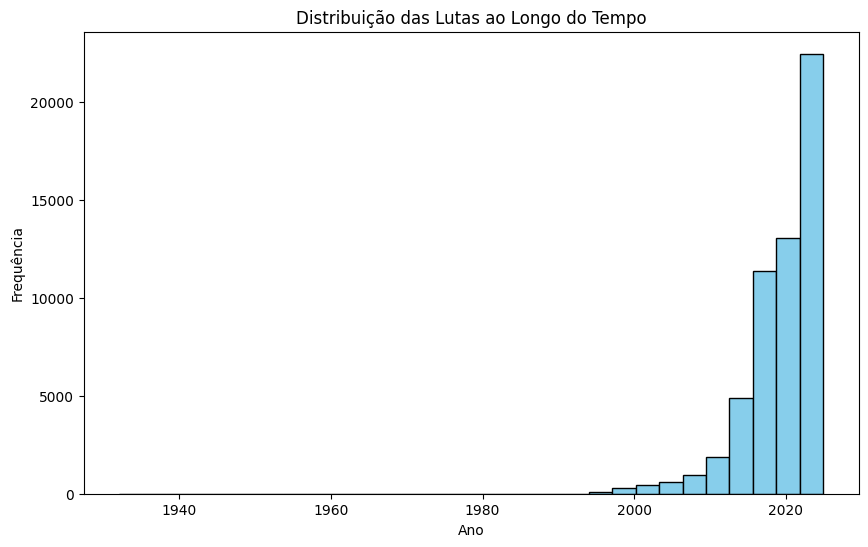

728
11396
True


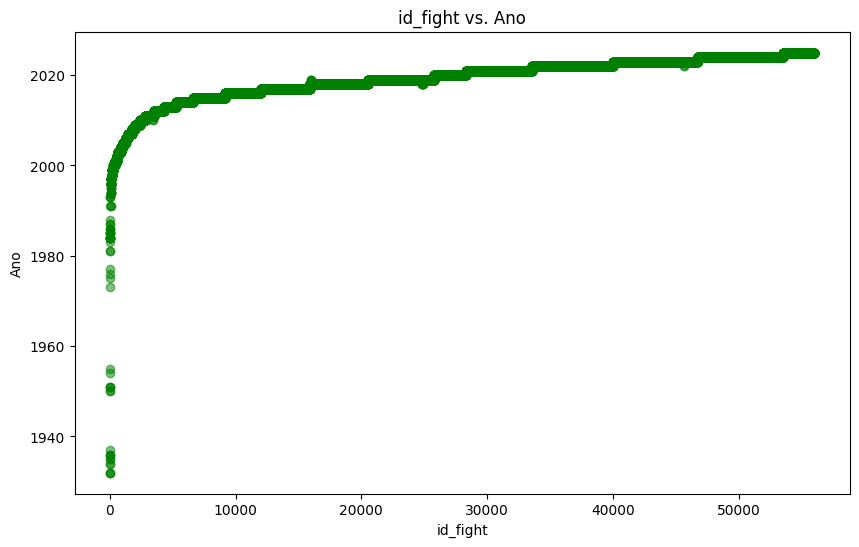

In [17]:
# Examinar a estrutura do DataFrame
print(df_fights.columns)
print(df_fights.dtypes)
df_fights.info()

# Analisar as distribuições das variáveis principais
print(df_fights['result'].value_counts())
print(df_fights['year'].value_counts())
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df_fights['year'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Ano')
plt.ylabel('Frequência')
plt.title('Distribuição das Lutas ao Longo do Tempo')
plt.show()

print(df_fights['fighter'].nunique())
print(df_fights['opponent'].nunique())

# Verificar a cronologia de id_fight
print(df_fights['id_fight'].is_monotonic_increasing)
plt.figure(figsize=(10, 6))
plt.scatter(df_fights['id_fight'], df_fights['year'], color='green', alpha=0.5)
plt.xlabel('id_fight')
plt.ylabel('Ano')
plt.title('id_fight vs. Ano')
plt.show()



## Preparando o DATASET para o Elo Rating

In [18]:
# Inicializar as pontuações Elo
df_fights['fighter_elo'] = 1500
df_fights['opponent_elo'] = 1500

# Converter 'id_fight' para numérico e tratar erros
try:
    df_fights['id_fight'] = pd.to_numeric(df_fights['id_fight'], errors='coerce')
except Exception as e:
    print(f"Ocorreu um erro durante a conversão de 'id_fight': {e}")
    # Investigar e corrigir os valores problemáticos em 'id_fight'
    problematic_rows = df_fights[df_fights['id_fight'].isnull()]
    if not problematic_rows.empty:
        print("Linhas problemáticas:")
        display(problematic_rows)

# Ordenar por 'id_fight'
df_fights = df_fights.sort_values('id_fight')

# Criar o dicionário de pontuações Elo
elo_ratings = {}
for fighter in df_fights['fighter'].unique():
    elo_ratings[fighter] = 1500
for opponent in df_fights['opponent'].unique():
    if opponent not in elo_ratings:
        elo_ratings[opponent] = 1500

# Exibir as primeiras linhas do DataFrame modificado para verificar as alterações
display(df_fights.head())

,fighter,opponent,result,competition,weight,year,id_fight,fighter_elo,opponent_elo
0,master-helio-gracie,antonio-portugal,W,Unknown,ABS,1932,1,1500,1500
1,master-helio-gracie,takashi-namiki,D,Unknown,ABS,1932,2,1500,1500
2,master-helio-gracie,fred-ebert,D,Unknown,ABS,1932,3,1500,1500
3,master-helio-gracie,wladek-zbyszko,D,Unknown,ABS,1934,4,1500,1500
4,master-helio-gracie,miyake,W,Unknown,ABS,1934,5,1500,1500


## Iterando as lutas e calculando



In [19]:
import math

# Iterar pelas lutas e atualizar as pontuações Elo
k_factor = 40
for index, fight in df_fights.iterrows():
    fighter = fight['fighter']
    opponent = fight['opponent']

    fighter_elo = elo_ratings[fighter]
    opponent_elo = elo_ratings[opponent]

    expected_fighter = 1 / (1 + 10**((opponent_elo - fighter_elo) / 400))
    expected_opponent = 1 / (1 + 10**((fighter_elo - opponent_elo) / 400))

    if fight['result'] == 'W':
        actual_fighter = 1
        actual_opponent = 0
    elif fight['result'] == 'L':
        actual_fighter = 0
        actual_opponent = 1
    else:  # Empate ou outro resultado
        actual_fighter = 0.5
        actual_opponent = 0.5

    new_fighter_elo = round(fighter_elo + k_factor * (actual_fighter - expected_fighter))
    new_opponent_elo = round(opponent_elo + k_factor * (actual_opponent - expected_opponent))

    elo_ratings[fighter] = new_fighter_elo
    elo_ratings[opponent] = new_opponent_elo

    df_fights.loc[index, 'fighter_elo_post'] = new_fighter_elo
    df_fights.loc[index, 'opponent_elo_post'] = new_opponent_elo

display(df_fights.head())


,fighter,opponent,result,competition,weight,year,id_fight,fighter_elo,opponent_elo,fighter_elo_post,opponent_elo_post
0,master-helio-gracie,antonio-portugal,W,Unknown,ABS,1932,1,1500,1500,1520.0,1480.0
1,master-helio-gracie,takashi-namiki,D,Unknown,ABS,1932,2,1500,1500,1519.0,1501.0
2,master-helio-gracie,fred-ebert,D,Unknown,ABS,1932,3,1500,1500,1518.0,1501.0
3,master-helio-gracie,wladek-zbyszko,D,Unknown,ABS,1934,4,1500,1500,1517.0,1501.0
4,master-helio-gracie,miyake,W,Unknown,ABS,1934,5,1500,1500,1536.0,1481.0


## Visualizando Dados

### Top 10 fighters:


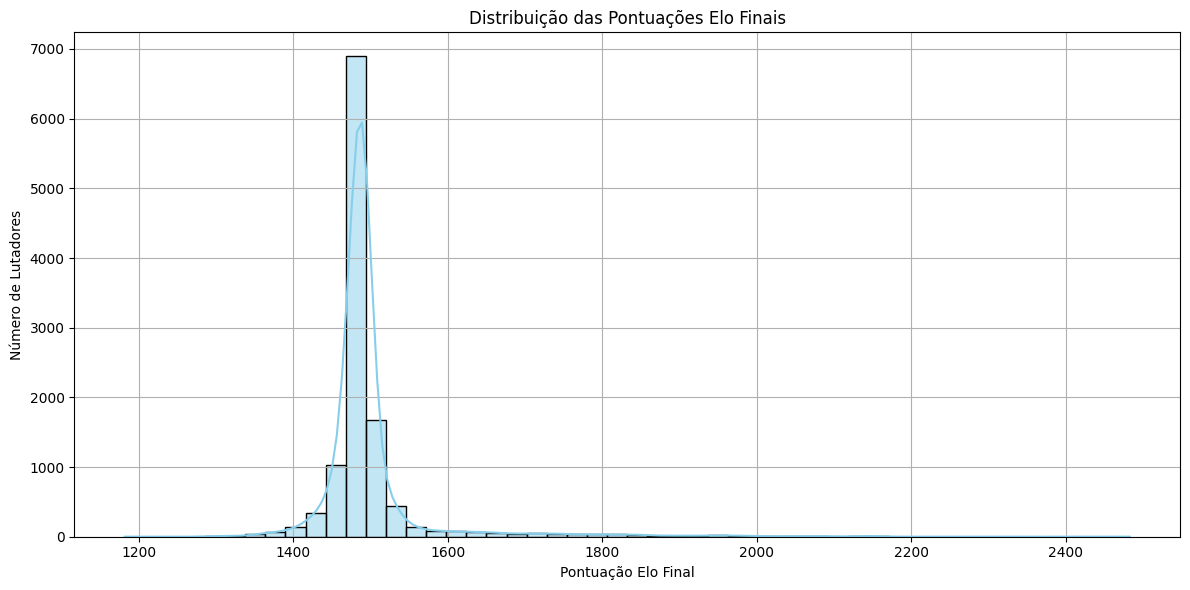

,Lutador,Elo Final
248,gordon-ryan,2483
292,nicholas-meregali,2445
501,erich-munis,2419
528,tainan-dalpra,2399
599,jansen-gomes,2389
440,gabrieli-pessanha,2335
549,micael-galvao,2334
119,marcus-buchecha-almeida,2298
283,adam-wardzinski,2295
420,victor-hugo,2279


Média da pontuação Elo: 1500.00
Desvio padrão: 80.65

Análise da Distribuição Elo:
A distribuição é assimétrica à direita (positivamente inclinada).


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extrair as pontuações Elo finais
final_elo_ratings = {fighter: elo for fighter, elo in elo_ratings.items()}

# Criar um DataFrame com as pontuações finais
final_elo_df = pd.DataFrame(list(final_elo_ratings.items()), columns=['Lutador', 'Elo Final'])

# Ordenar o DataFrame pela pontuação Elo de forma decrescente
final_elo_df_sorted = final_elo_df.sort_values(by='Elo Final', ascending=False)

# Visualizar a distribuição das pontuações Elo finais com histograma + curva de densidade
plt.figure(figsize=(12, 6))
sns.histplot(final_elo_df['Elo Final'], bins=50, kde=True, color='skyblue', edgecolor='black')
plt.xlabel('Pontuação Elo Final')
plt.ylabel('Número de Lutadores')
plt.title('Distribuição das Pontuações Elo Finais')
plt.grid(True)
plt.tight_layout()
plt.show()

# Exibir o top 10 lutadores
display(final_elo_df_sorted.head(10))

# Informações estatísticas básicas
media = final_elo_df['Elo Final'].mean()
desvio = final_elo_df['Elo Final'].std()
print(f"Média da pontuação Elo: {media:.2f}")
print(f"Desvio padrão: {desvio:.2f}")

# Analisar a simetria da distribuição
print("\nAnálise da Distribuição Elo:")
skew = final_elo_df['Elo Final'].skew()
if skew > 0.5:
    print("A distribuição é assimétrica à direita (positivamente inclinada).")
elif skew < -0.5:
    print("A distribuição é assimétrica à esquerda (negativamente inclinada).")
else:
    print("A distribuição é aproximadamente simétrica.")




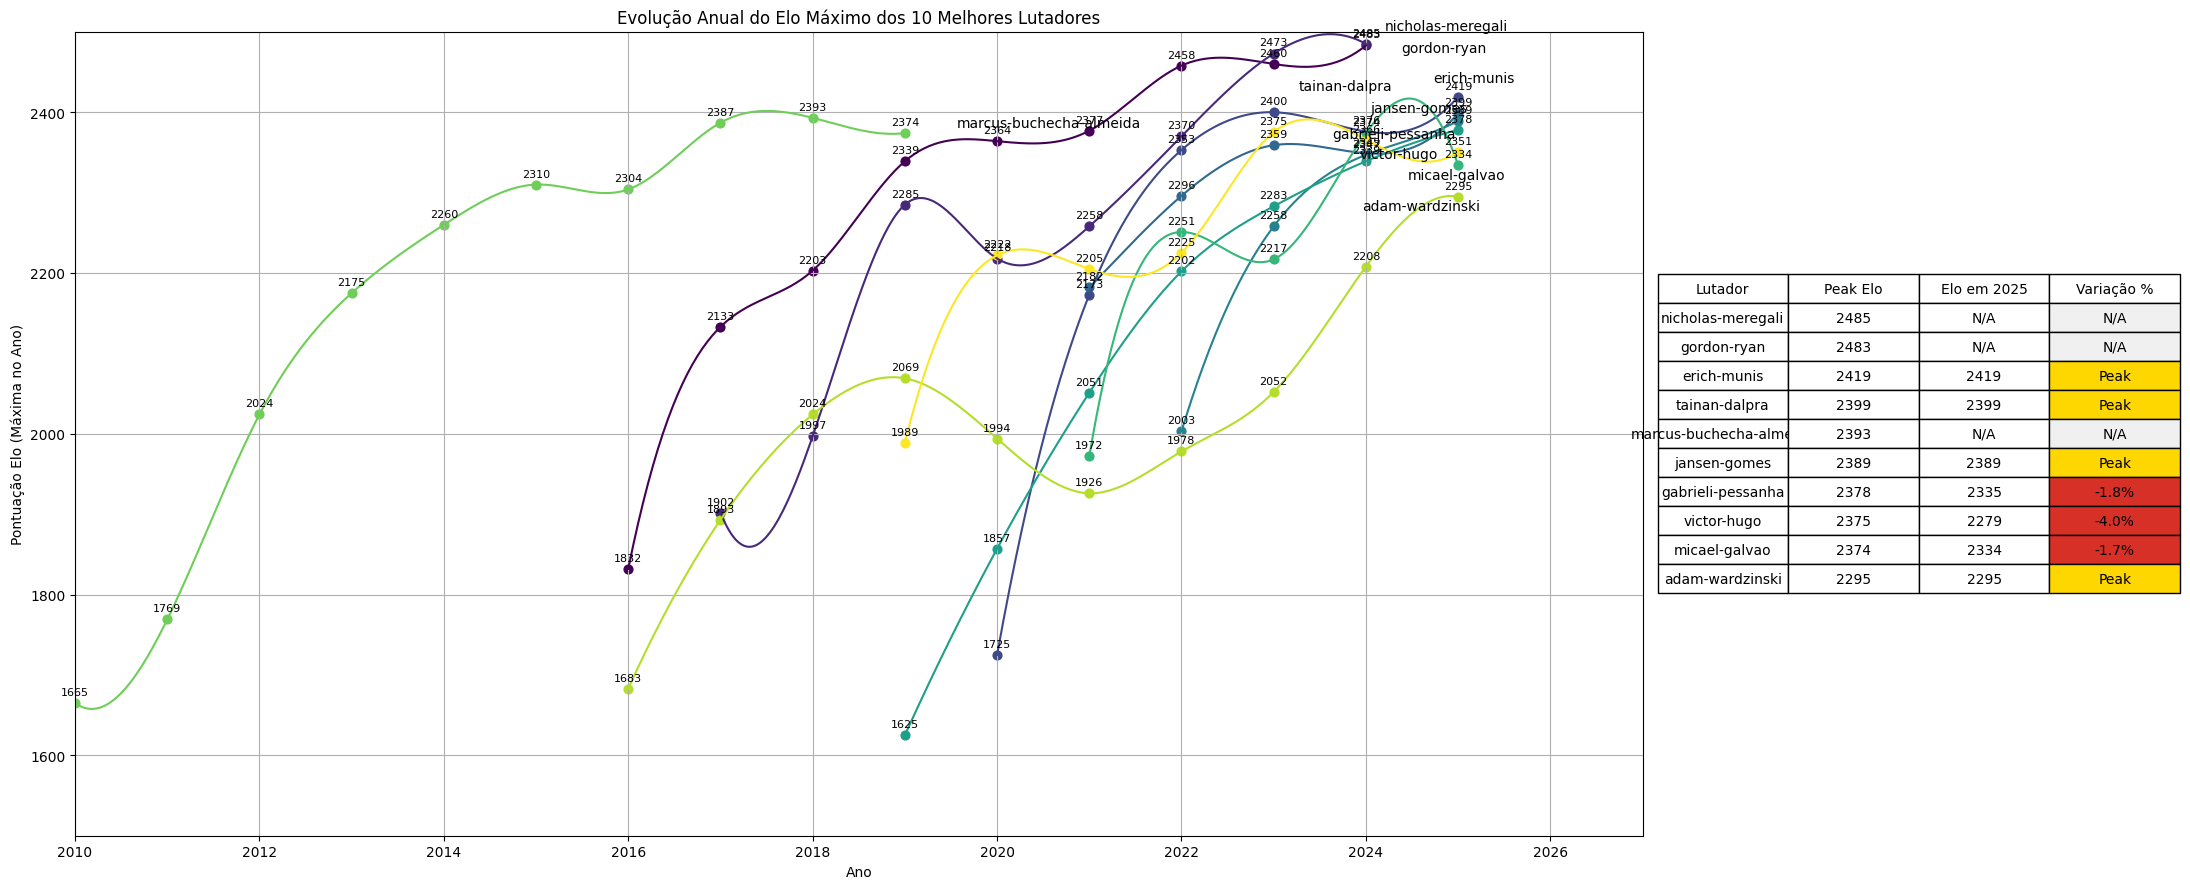

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
from adjustText import adjust_text
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

# === 1. Preparar os dados ===
top_fighters = final_elo_df_sorted.head(10)['Lutador'].tolist()
dados_tabela = []
dados_linhas = {}

for fighter in top_fighters:
    df = df_fights[(df_fights['fighter'] == fighter) | (df_fights['opponent'] == fighter)].copy()
    df = df.sort_values(by=['year', 'id_fight'])

    df['elo'] = df.apply(
        lambda row: row['fighter_elo_post'] if row['fighter'] == fighter else row['opponent_elo_post'],
        axis=1
    )

    peak_elo = df['elo'].max()
    elo_2025 = df[df['year'] == 2025].sort_values(by='id_fight')['elo'].iloc[-1] if not df[df['year'] == 2025].empty else None

    if elo_2025 is not None and isinstance(elo_2025, (int, float)):
        if elo_2025 == peak_elo:
            var_label = "Peak"
            var_color = "#FFD700"
        else:
            var_pct = ((elo_2025 - peak_elo) / peak_elo) * 100
            var_label = f"{var_pct:.1f}%"
            var_color = "#1a9850" if var_pct > 0 else "#d73027"
    else:
        var_label = "N/A"
        var_color = "#f0f0f0"

    dados_tabela.append({
        'Lutador': fighter,
        'Peak Elo': peak_elo,
        'Elo em 2025': elo_2025 if elo_2025 is not None else 'N/A',
        'Variação': var_label,
        'Cor': var_color
    })

    max_por_ano = df.groupby('year')['elo'].max().reset_index()
    dados_linhas[fighter] = max_por_ano

# Converte para DataFrame ordenado por Peak Elo
tabela_info = pd.DataFrame(dados_tabela).sort_values(by='Peak Elo', ascending=False)

# === 2. Layout com gráfico e tabela ===
fig = plt.figure(figsize=(22, 9))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
ax0 = plt.subplot(gs[0])

# Paleta de cores
cmap = plt.get_cmap('viridis', len(top_fighters))
colors = [mcolors.to_hex(cmap(i)) for i in range(len(top_fighters))]

# === 3. Gráfico suavizado com texto nas bolinhas ===
min_ano, max_ano = float('inf'), float('-inf')
label_positions = {}
for i, fighter in enumerate(top_fighters):
    data = dados_linhas[fighter]
    x = data['year'].values.astype(float)
    y = data['elo'].values
    min_ano = min(min_ano, x.min())
    max_ano = max(max_ano, x.max())

    if len(x) > 3:
        x_smooth = np.linspace(x.min(), x.max(), 300)
        try:
            spline = make_interp_spline(x, y, k=3)
            y_smooth = spline(x_smooth)
            ax0.plot(x_smooth, y_smooth, label=fighter, color=colors[i])
            label_positions[fighter] = (x_smooth[-1], y_smooth[-1])
        except ValueError:
            ax0.plot(x, y, linestyle='-', label=fighter, color=colors[i])
            label_positions[fighter] = (x[-1], y[-1])
    else:
        ax0.plot(x, y, linestyle='-', label=fighter, color=colors[i])
        label_positions[fighter] = (x[-1], y[-1])

    ax0.scatter(x, y, color=colors[i], s=40)
    for xi, yi in zip(x, y):
        ax0.text(xi, yi + 10, f"{int(yi)}", fontsize=8, ha='center', color='black')

# Ajusta texto dos nomes com overlap
texts = []
for fighter, (x_label, y_label) in label_positions.items():
    texts.append(ax0.text(x_label + 0.2, y_label, fighter, fontsize=10, color='black'))

adjust_text(texts, ax=ax0)

ax0.set_xlim([min_ano, max_ano + 2])
ax0.set_ylim(bottom=1500, top=2500)
ax0.set_xlabel("Ano")
ax0.set_ylabel("Pontuação Elo (Máxima no Ano)")
ax0.set_title("Evolução Anual do Elo Máximo dos 10 Melhores Lutadores")
ax0.grid(True)

# === 4. Criar a tabela ===
ax1 = plt.subplot(gs[1])
ax1.axis('off')

column_labels = ['Lutador', 'Peak Elo', 'Elo em 2025', 'Variação %']
cell_data = []
color_map = []

for _, row in tabela_info.iterrows():
    peak = int(row['Peak Elo'])
    atual = int(row['Elo em 2025']) if isinstance(row['Elo em 2025'], (int, float)) else 'N/A'
    var_label = row['Variação']
    var_color = row['Cor']

    cell_data.append([row['Lutador'], peak, atual, var_label])
    color_map.append(var_color)

# Cria a tabela
tabela = ax1.table(
    cellText=cell_data,
    colLabels=column_labels,
    loc='center',
    cellLoc='center',
    colLoc='center'
)
tabela.auto_set_font_size(False)
tabela.set_fontsize(10)
tabela.scale(1, 1.5)

# Aplica a cor de fundo na coluna de variação
for i, color in enumerate(color_map, start=1):
    tabela[(i, 3)].set_facecolor(color)

# === 5. Mostrar tudo ===
plt.tight_layout()
plt.show()


In [22]:
# Define os lutadores a acompanhar
lutadores = ['gordon-ryan', 'nicholas-meregali']

# Armazena as tabelas de cada lutador
tabelas_max_ano = []

for lutador in lutadores:
    # Filtra lutas onde o lutador aparece
    lutas = df_fights[
        (df_fights['fighter'] == lutador) | (df_fights['opponent'] == lutador)
    ].copy().sort_values(by=['year', 'id_fight'])

    # Cria coluna com Elo pós-luta correto
    lutas['elo_post'] = lutas.apply(
        lambda row: row['fighter_elo_post'] if row['fighter'] == lutador else row['opponent_elo_post'],
        axis=1
    )

    # Filtra até 2025
    lutas = lutas[lutas['year'] <= 2025]

    # Agrupa por ano e pega o Elo máximo do ano
    max_por_ano = lutas.groupby('year')['elo_post'].max().reset_index()
    max_por_ano.columns = ['year', lutador]

    tabelas_max_ano.append(max_por_ano)

# Junta as duas tabelas em uma única com merge por ano
tabela_final = pd.merge(tabelas_max_ano[0], tabelas_max_ano[1], on='year', how='outer').sort_values(by='year')

tabela_final

,year,gordon-ryan,nicholas-meregali
0,2016,1832.0,NaN
1,2017,2133.0,1902.0
2,2018,2203.0,1997.0
3,2019,2339.0,2285.0
4,2020,2364.0,2218.0
5,2021,2377.0,2258.0
6,2022,2458.0,2370.0
7,2023,2460.0,2473.0
8,2024,2483.0,2485.0


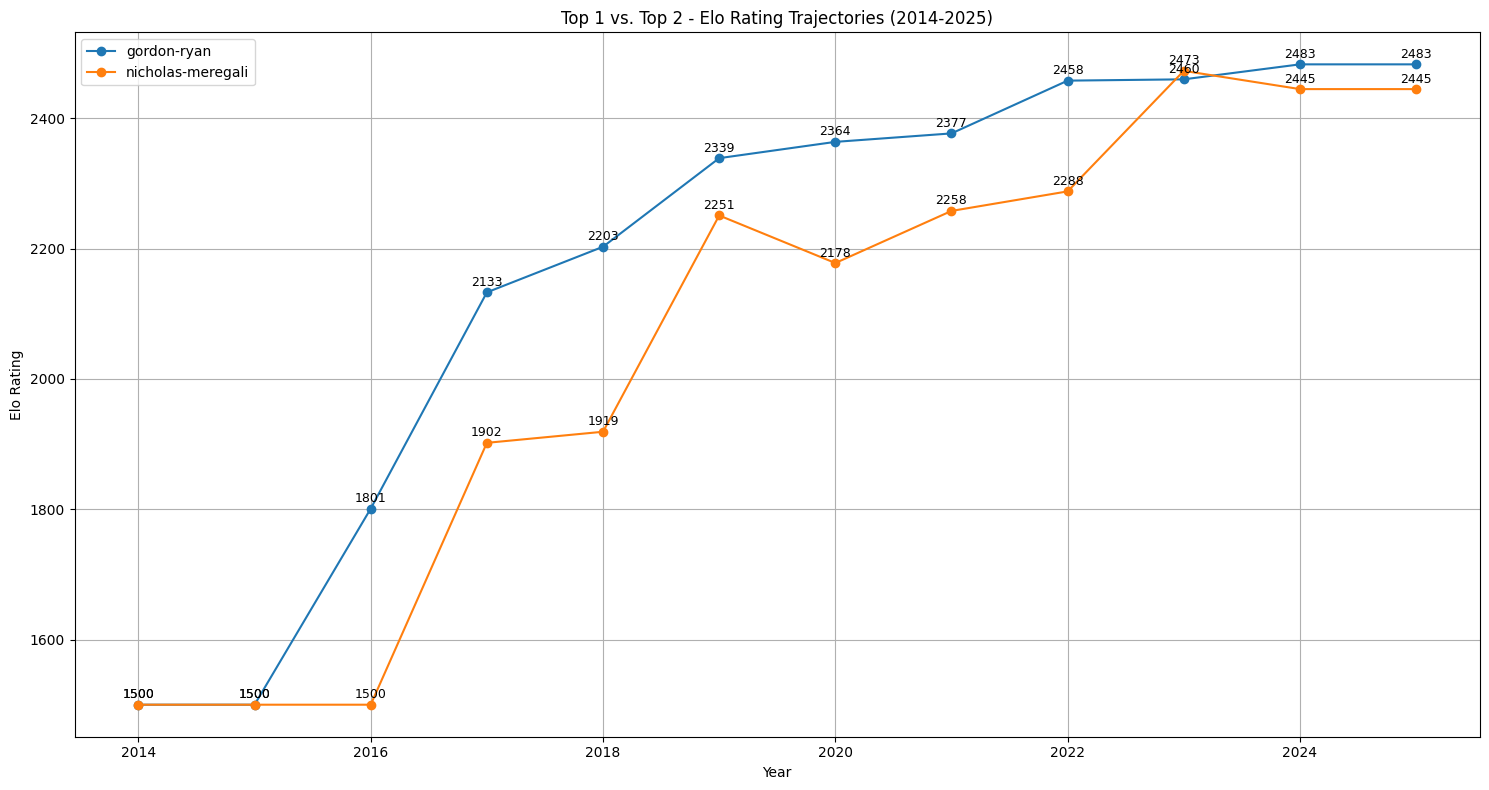

In [23]:
fighters_to_compare = ['gordon-ryan', 'nicholas-meregali']
years_to_track = range(2014, 2026)  # 2014 até 2025

plt.figure(figsize=(15, 8))

for fighter in fighters_to_compare:
    fighter_data = df_fights[(df_fights['fighter'] == fighter) | (df_fights['opponent'] == fighter)]
    fighter_data = fighter_data.sort_values(by=['year', 'id_fight'])

    elo_values_by_year = {}
    for year in years_to_track:
        year_data = fighter_data[fighter_data['year'] == year]
        if not year_data.empty:
            last_elo_of_year = (
                year_data.iloc[-1]['fighter_elo_post']
                if year_data.iloc[-1]['fighter'] == fighter
                else year_data.iloc[-1]['opponent_elo_post']
            )
            elo_values_by_year[year] = last_elo_of_year
        else:
            elo_values_by_year[year] = elo_values_by_year.get(year - 1, 1500)

    years = list(elo_values_by_year.keys())
    elos = list(elo_values_by_year.values())

    # Linha com bolinhas
    plt.plot(years, elos, label=fighter, marker='o', linestyle='-')

    # Valor do Elo acima de cada ponto
    for x, y in zip(years, elos):
        plt.text(x, y + 10, f"{int(y)}", ha='center', fontsize=9)

plt.xlabel("Year")
plt.ylabel("Elo Rating")
plt.title("Top 1 vs. Top 2 - Elo Rating Trajectories (2014-2025)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Analise dos Dados



**Principais Resultados da Análise de Dados**

**Cálculo da Pontuação Elo:** As pontuações Elo foram calculadas com sucesso para cada lutador com base nos resultados das lutas, utilizando um K-factor de 40.

A coluna id_fight foi usada para garantir a ordem cronológica das lutas. Duas novas colunas (fighter_elo_post e opponent_elo_post) foram adicionadas ao DataFrame para armazenar as pontuações Elo pós-luta.

**Top 10 Lutadores:** Os 10 melhores lutadores foram identificados com base na maior pontuação Elo alcançada em todas as lutas. Uma visualização mostra suas trajetórias de pontuação Elo ao longo do tempo. Gordon Ryan teve a maior pontuação Elo (2483).

**Distribuição do Elo:** A distribuição das pontuações finais Elo é positivamente assimétrica, com uma pontuação média em torno de 1500. A presença de outliers sugere que alguns lutadores têm pontuações significativamente mais altas ou mais baixas do que a maioria.

**OBS:**


**Refinar o Modelo Elo:** Experimentar com diferentes K-factors ou métodos de cálculo de pontuação Elo para ver se eles melhoram a precisão e o poder preditivo do modelo. Considerar incorporar classes de peso ou outros detalhes das lutas para rankings mais detalhados.


In [24]:
final_elo_df_sorted

,Lutador,Elo Final
248,gordon-ryan,2483
292,nicholas-meregali,2445
501,erich-munis,2419
528,tainan-dalpra,2399
599,jansen-gomes,2389
...,...,...
1664,oliver-geddes,1289
7013,marlon-tanaka,1288
5547,thiago-andrade,1285
790,wellington-dias,1236


<ipython-input-25-b5e726763baf>:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([groups_df[groups_df['Group'] == group]['Elo'] for group in group_names],


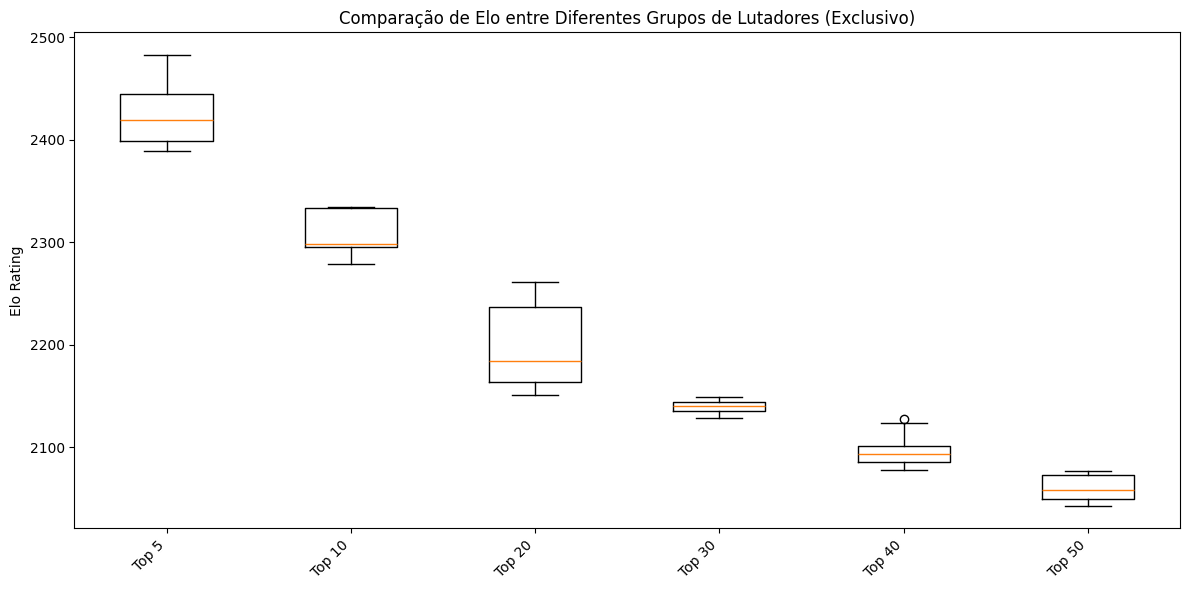

Top 5:
  Média: 2427.00
  Mínimo: 2389.00
  Máximo: 2483.00
--------------------
Top 10:
  Média: 2308.20
  Mínimo: 2279.00
  Máximo: 2335.00
--------------------
Top 20:
  Média: 2199.20
  Mínimo: 2151.00
  Máximo: 2261.00
--------------------
Top 30:
  Média: 2139.50
  Mínimo: 2129.00
  Máximo: 2149.00
--------------------
Top 40:
  Média: 2097.20
  Mínimo: 2078.00
  Máximo: 2128.00
--------------------
Top 50:
  Média: 2059.80
  Mínimo: 2043.00
  Máximo: 2077.00
--------------------


In [25]:
import matplotlib.pyplot as plt


# Definir os grupos de lutadores
group_sizes = [5, 10, 20, 30, 40, 50]
group_names = ['Top 5', 'Top 10', 'Top 20', 'Top 30', 'Top 40', 'Top 50']

# Criar um DataFrame com os dados dos grupos, excluindo lutadores dos grupos anteriores
groups_data = []
previous_fighters = []
for size, name in zip(group_sizes, group_names):
    current_fighters = final_elo_df_sorted['Lutador'].head(size).tolist()
    fighters = [f for f in current_fighters if f not in previous_fighters]

    for fighter in fighters:
        elo = final_elo_df_sorted.loc[final_elo_df_sorted['Lutador'] == fighter,  'Elo Final'].iloc[0]
        groups_data.append([name, fighter, elo])

    previous_fighters.extend(fighters)

groups_df = pd.DataFrame(groups_data, columns=['Group', 'Lutador', 'Elo'])

# Criar o boxplot
plt.figure(figsize=(12, 6))
plt.boxplot([groups_df[groups_df['Group'] == group]['Elo'] for group in group_names],
            labels=group_names)
plt.title('Comparação de Elo entre Diferentes Grupos de Lutadores (Exclusivo)')
plt.ylabel('Elo Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



# Definir os grupos de lutadores
group_sizes = [5, 10, 20, 30, 40, 50]
group_names = ['Top 5', 'Top 10', 'Top 20', 'Top 30', 'Top 40', 'Top 50']

# Calcular e exibir as estatísticas para cada grupo, excluindo os lutadores dos grupos anteriores
previous_fighters = []  # Inicializa uma lista vazia para armazenar os lutadores dos grupos anteriores
for size, name in zip(group_sizes, group_names):
    # Obter os lutadores no grupo atual, excluindo os lutadores dos grupos anteriores
    current_fighters = final_elo_df_sorted['Lutador'].head(size).tolist()
    fighters = [f for f in current_fighters if f not in previous_fighters]

    # Obter os Elos dos lutadores no grupo atual
    elos = final_elo_df_sorted.loc[final_elo_df_sorted['Lutador'].isin(fighters), 'Elo Final']

    # Calcular a média, mínimo e máximo
    media = elos.mean()
    minimo = elos.min()
    maximo = elos.max()

    # Exibir os resultados
    print(f"{name}:")
    print(f"  Média: {media:.2f}")
    print(f"  Mínimo: {minimo:.2f}")
    print(f"  Máximo: {maximo:.2f}")
    print("-" * 20)  # Separador entre os grupos

    # Atualiza a lista de lutadores dos grupos anteriores
    previous_fighters.extend(fighters)

In [26]:
def calcular_brier_score(df_fights, elo_ratings):
  """Calcula o Brier Score do sistema de ranking Elo.

  Args:
    df_fights: DataFrame contendo os dados das lutas.
    elo_ratings: Dicionário contendo os ratings Elo de todos os lutadores.

  Returns:
    O Brier Score do sistema de ranking Elo.
  """
  brier_score = 0
  total_lutas = 0

  for index, fight in df_fights.iterrows():
    fighter1 = fight['fighter']
    fighter2 = fight['opponent']
    resultado = fight['result']

    elo1 = elo_ratings[fighter1]
    elo2 = elo_ratings[fighter2]

    # Calcular a probabilidade de vitória do fighter1
    prob1 = 1 / (1 + 10**((elo2 - elo1) / 400))

    # Calcular a contribuição da luta para o Brier Score
    if resultado == 'W':
      brier_score += (1 - prob1)**2  # (Resultado real - probabilidade prevista)^2
    elif resultado == 'L':
      brier_score += (0 - prob1)**2
    else: # Empate
      brier_score += (0.5 - prob1)**2

    total_lutas += 1

  # Calcular o Brier Score médio
  brier_score /= total_lutas

  return brier_score

# Calcular e exibir o Brier Score
brier_score = calcular_brier_score(df_fights, elo_ratings)
print(f"Brier Score do sistema de ranking Elo: {brier_score}")

Brier Score do sistema de ranking Elo: 0.13976628793013118


### Clusterização para separar em grupos distintos

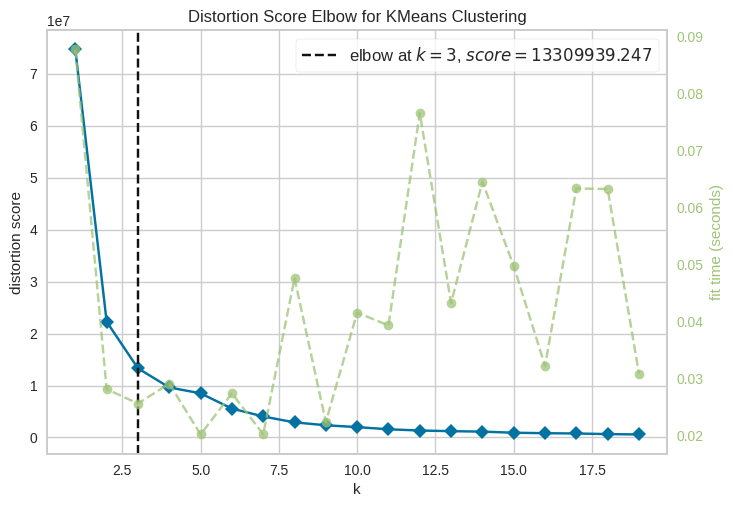

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:


import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

# Extraia os ratings Elo finais
elo_data = final_elo_df_sorted[['Lutador', 'Elo Final']]

# Crie um novo DataFrame com os ratings Elo
X = elo_data[['Elo Final']]

# Define o intervalo de valores de K que vamos testar
K = range(1, 20)

# Inicializa o visualizador KElbowVisualizer
visualizer = KElbowVisualizer(KMeans(random_state=42), k=K)

# Ajusta o visualizador aos dados
visualizer.fit(X)

# Mostra o gráfico do método Elbow
visualizer.show()

           count         mean         std     min     25%     50%     75%  \
Cluster                                                                     
0        10840.0  1483.976015   26.670926  1182.0  1479.0  1486.0  1493.0   
1          154.0  2009.298701  137.350805  1853.0  1911.0  1966.5  2079.5   
2          487.0  1695.581109   74.781417  1590.0  1630.0  1682.0  1753.5   

            max  
Cluster          
0        1589.0  
1        2483.0  
2        1849.0  


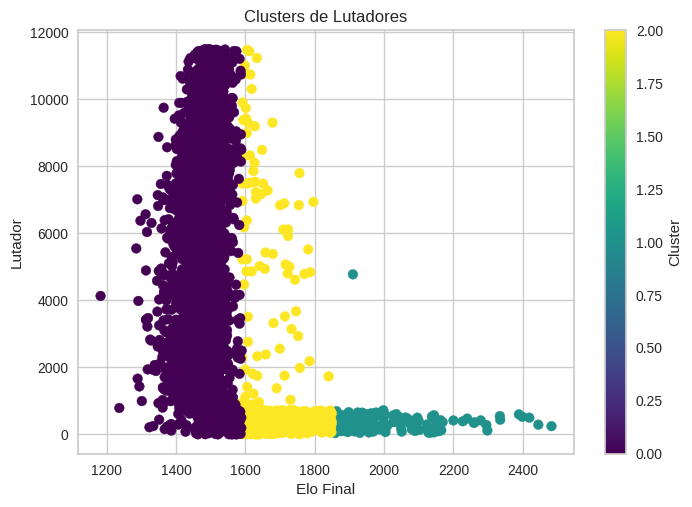

In [28]:
# Aplicar o algoritmo KMeans com K=3
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X)
labels = kmeans.labels_

# Adicionar os rótulos dos clusters ao DataFrame
elo_data['Cluster'] = labels

# Analisar os resultados
# Estatísticas descritivas
cluster_stats = elo_data.groupby('Cluster')['Elo Final'].describe()
print(cluster_stats)

plt.scatter(elo_data['Elo Final'], elo_data.index, c=elo_data['Cluster'], cmap='viridis')
plt.title('Clusters de Lutadores')
plt.xlabel('Elo Final')
plt.ylabel('Lutador')
plt.colorbar(label='Cluster') # Adiciona uma barra de cores
plt.show()


In [47]:
}# Padronizar nomes de colunas em elo_data
elo_data = elo_data.rename(columns={
    'Lutador': 'fighter',
    'Cluster': 'fighter_cluster'
})

# Agora fazer o merge com df_fights
df_fights = df_fights.merge(elo_data[['fighter', 'fighter_cluster']], on='fighter', how='left')


In [32]:
elo_data.to_csv('elo_data.csv', index=False)

In [31]:
# prompt: quantos lutadores sao cluster 0,1 e 2.

cluster_counts = elo_data['fighter_cluster'].value_counts().sort_index()
print("Número de lutadores por cluster:")
cluster_counts


Número de lutadores por cluster:


,count
Cluster,
0,10840
1,154
2,487


In [50]:
elo_data

,fighter,Elo Final,fighter_cluster
248,gordon-ryan,2483,1
292,nicholas-meregali,2445,1
501,erich-munis,2419,1
528,tainan-dalpra,2399,1
599,jansen-gomes,2389,1
...,...,...,...
1664,oliver-geddes,1289,0
7013,marlon-tanaka,1288,0
5547,thiago-andrade,1285,0
790,wellington-dias,1236,0


In [49]:
# prompt: faça a media do elo final de cada fighter_cluster 1,0 e 2, use a coluna Elo Final

# Faça a média do elo final para cada cluster
media_elo_por_cluster = elo_data.groupby('fighter_cluster')['Elo Final'].mean()

# Exiba a média do elo final para cada cluster
print("Média do Elo Final por Cluster:")
media_elo_por_cluster

Média do Elo Final por Cluster:


,Elo Final
fighter_cluster,
0,1483.976015
1,2009.298701
2,1695.581109


In [55]:
# Calcular número de lutas por atleta em cada cluster
lutas_por_atleta = df_fights.groupby(['fighter', 'fighter_cluster']).size().reset_index(name='n_lutas')
media_lutas_por_atleta = lutas_por_atleta.groupby('fighter_cluster')['n_lutas'].mean().reset_index()
media_lutas_por_atleta = media_lutas_por_atleta.rename(columns={'n_lutas': 'Número Médio de Lutas por Atleta'})
avg_opponent_elo_per_cluster = media_elo_por_cluster.reset_index()
avg_opponent_elo_per_cluster = avg_opponent_elo_per_cluster.rename(columns={'Elo Final': 'Nível Médio de Oponentes'})

# Calcular estatísticas por cluster
cluster_stats = df_fights.groupby('fighter_cluster').agg(
    win_rate=('result', lambda x: (x == 'W').mean()),  # % de vitórias
    sub_rate=('result', lambda x: (x == 'W').sum() / ((x != 'D').sum() if (x != 'D').sum() > 0 else 1))  # Finalizações por luta
).reset_index()

# Merge com média de lutas por atleta e ELO médio dos oponentes
cluster_stats = cluster_stats.merge(media_lutas_por_atleta, on='fighter_cluster')
cluster_stats = cluster_stats.merge(avg_opponent_elo_per_cluster, on='fighter_cluster')


# Renomear colunas
cluster_stats = cluster_stats.rename(columns={
    'win_rate': '% de Vitórias',
    'sub_rate': 'Finalizações por Luta'
})

# Converter para percentual
cluster_stats['% de Vitórias'] = (cluster_stats['% de Vitórias'] * 100).round(1)
cluster_stats['Finalizações por Luta'] = (cluster_stats['Finalizações por Luta'] * 100).round(1)

# Reorganizar colunas
cols_ordem = ['fighter_cluster', 'Número Médio de Lutas por Atleta', '% de Vitórias',
              'Nível Médio de Oponentes', 'Finalizações por Luta']
cluster_stats = cluster_stats[cols_ordem]

# Mostrar resultado
print(cluster_stats)

   fighter_cluster  Número Médio de Lutas por Atleta  % de Vitórias  \
0                0                         53.647399           55.1   
1                1                        114.725490           79.3   
2                2                         72.646766           68.7   

   Nível Médio de Oponentes  Finalizações por Luta  
0               1483.976015                   55.5  
1               2009.298701                   80.0  
2               1695.581109                   69.4  


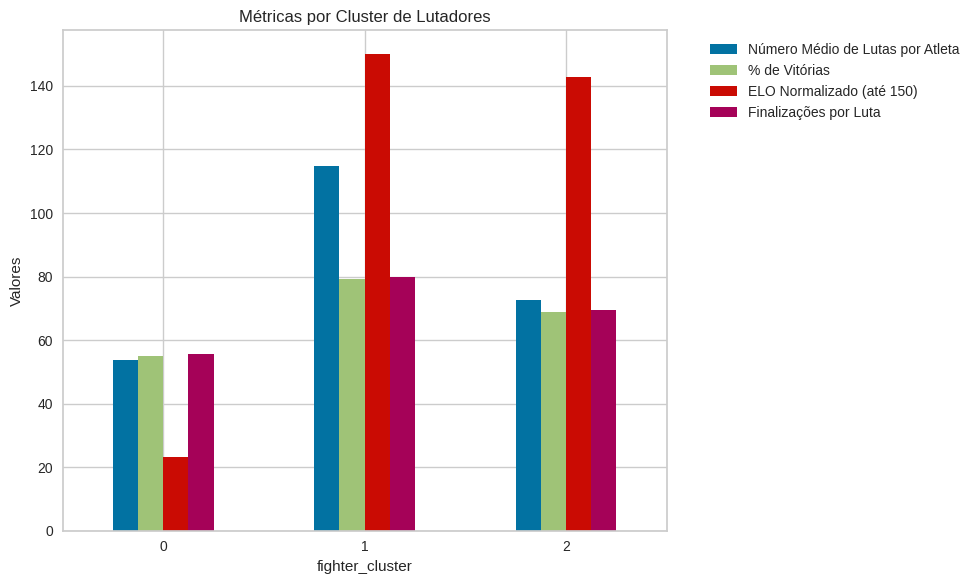

In [36]:
import matplotlib.pyplot as plt

cluster_stats.set_index('fighter_cluster').plot(kind='bar', figsize=(10, 6))
plt.title("Métricas por Cluster de Lutadores")
plt.ylabel("Valores")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<ipython-input-57-ee3ce242597e>:38: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-57-ee3ce242597e>:38: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-57-ee3ce242597e>:38: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-57-ee3ce242597e>:38: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



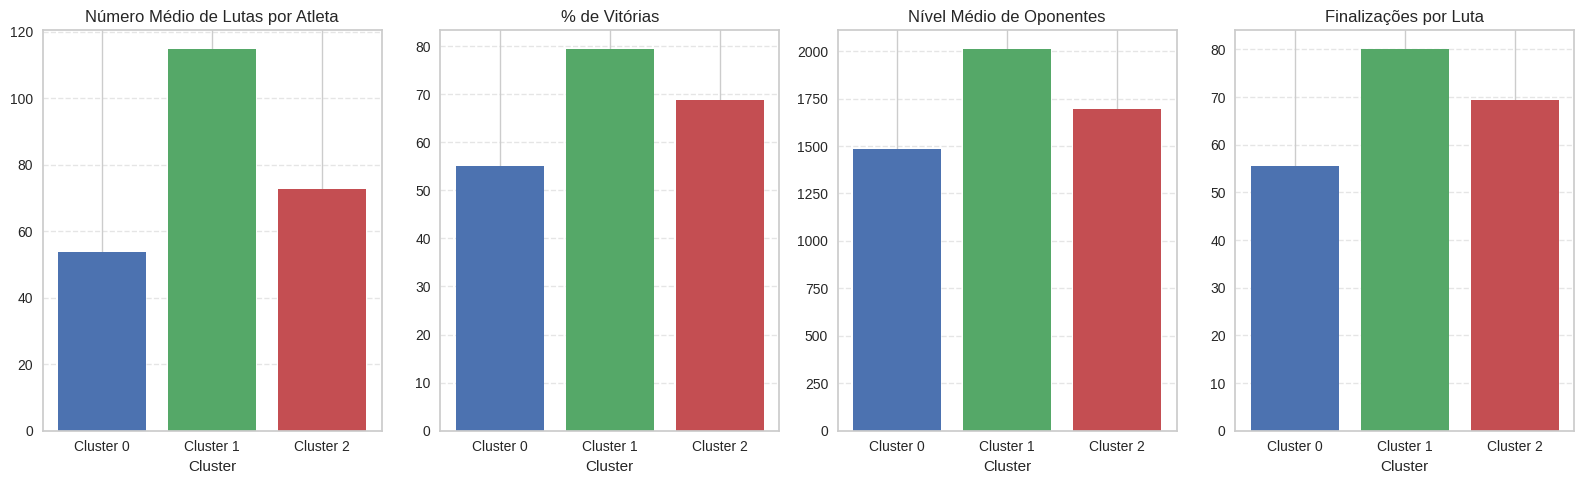

In [57]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Renomear os clusters para melhor visualização
cluster_stats['fighter_cluster_name'] = cluster_stats['fighter_cluster'].astype(str).replace({
    '0': 'Cluster 0',
    '1': 'Cluster 1',
    '2': 'Cluster 2'
})

# Defina suas cores para cada cluster
color_map = {
    'Cluster 0': '#4c72b0',  # azul
    'Cluster 1': '#55a868',  # verde
    'Cluster 2': '#c44e52'   # vermelho
}

# Métricas a serem plotadas, incluindo o ELO Médio original
vars_to_plot = [
    'Número Médio de Lutas por Atleta',
    '% de Vitórias',
    'Nível Médio de Oponentes', # Mudado para a coluna
    'Finalizações por Luta'
]

fig, axes = plt.subplots(1, len(vars_to_plot), figsize=(4 * len(vars_to_plot), 5))

for ax, col in zip(axes, vars_to_plot):
    # Ordenar para garantir que as barras fiquem na ordem 0, 1, 2
    stats_sorted = cluster_stats.sort_values('fighter_cluster')
    clusters = stats_sorted['fighter_cluster_name']
    values = stats_sorted[col]

    # Para cada barra, escolhe a cor baseada no cluster
    colors = [color_map[c] for c in clusters]
    ax.bar(clusters, values, color=colors)
    ax.set_title(col)
    ax.set_xticklabels(clusters, rotation=0, ha='center')
    ax.set_xlabel('Cluster')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()